In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.utils import get_file
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import confusion_matrix
from PIL import Image
  
from keras_preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.datasets import mnist
 
import pandas as pd
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import cv2
import requests
from io import BytesIO
 
 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now, let's import our training and testing dataset to build a model that will allow us to recognize handwritten numbers. We will "massage" the data a bit to optimize the process and make it work properly. Tihs means, we will re-shape each image in the training-testing sets (depending on what the set up from Keras is), and we will normalize the pixel intensity so it lies between 0 and 1 (instead of 0 to 255).

For the outcome labels, we will convert them from integers to vectors:

In [3]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

if K.image_data_format() == "channels_first":
	X_train = X_train.reshape((X_train.shape[0], 1, 28, 28))
	testData = testData.reshape((testData.shape[0], 1, 28, 28))
 
else:
	X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
	X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
 
 # scale data to the range of [0, 1]
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# "Binarify" the labels (from categorical to vectors)
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

print(num_classes)
print(y_test)
print(X_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
10
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(10000, 28, 28, 1)


It's time to build our model. What layers can you identify?

In [4]:
def large_model():
# create model
    model = Sequential()
    model.add(ZeroPadding2D(padding=(2, 2), input_shape=(28,28,1), data_format=None))
    model.add(Conv2D(32, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
# Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

And now comes the training and testing

In [5]:
model = large_model()
# Fit and train the model using only MNIST data for both training and evaluation
H = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=200)
# Final evaluation of the model using MNIST testing data
scores = model.evaluate(X_test, y_test, verbose=0)
print(scores)

Epoch 1/15
300/300 [==============================] - 14s 12ms/step - loss: 0.3165 - accuracy: 0.9054 - val_loss: 0.0849 - val_accuracy: 0.9723
Epoch 2/15
300/300 [==============================] - 3s 11ms/step - loss: 0.0784 - accuracy: 0.9761 - val_loss: 0.0454 - val_accuracy: 0.9849
Epoch 3/15
300/300 [==============================] - 3s 11ms/step - loss: 0.0569 - accuracy: 0.9821 - val_loss: 0.0346 - val_accuracy: 0.9887
Epoch 4/15
300/300 [==============================] - 3s 11ms/step - loss: 0.0458 - accuracy: 0.9857 - val_loss: 0.0323 - val_accuracy: 0.9891
Epoch 5/15
300/300 [==============================] - 3s 11ms/step - loss: 0.0378 - accuracy: 0.9880 - val_loss: 0.0409 - val_accuracy: 0.9861
Epoch 6/15
300/300 [==============================] - 3s 11ms/step - loss: 0.0321 - accuracy: 0.9896 - val_loss: 0.0289 - val_accuracy: 0.9908
Epoch 7/15
300/300 [==============================] - 3s 11ms/step - loss: 0.0278 - accuracy: 0.9908 - val_loss: 0.0286 - val_accuracy: 0.990

Let's check some diagnosis:

In [6]:
predictions = model.predict(X_test, batch_size=128)
print(predictions[0])
print(len(predictions[0]))


[6.3711314e-13 4.1605303e-10 2.9402598e-09 2.4953948e-09 1.8144359e-09
 1.2775079e-11 2.4556621e-13 9.9999988e-01 1.5228756e-12 9.6890801e-08]
10


In [7]:
print(classification_report(y_test.argmax(axis=1),
	predictions.argmax(axis=1),
	target_names=[str(x) for x in np.array(list(range(num_classes)), dtype='uint8')]))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



And the history of loss and accuracy to track overfitting:

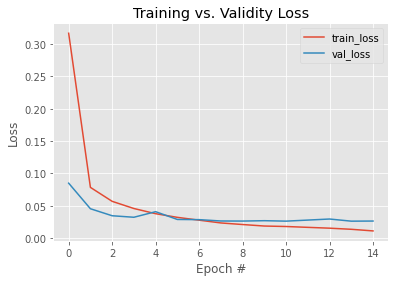

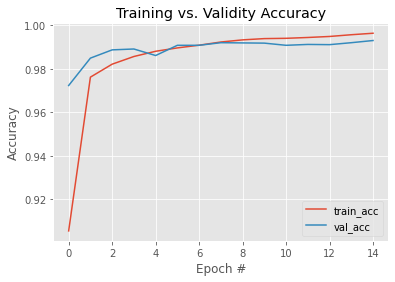

In [8]:
# A nice function to plot loss and accuracy histories
def plot_training(H, N, plotPath, type="loss"):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    if type=="loss":
        plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
        plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
        plt.title("Training vs. Validity Loss")
        plt.ylabel("Loss")
        plt.legend(loc="upper right")

    else: 
        plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
        plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
        plt.title("Training vs. Validity Accuracy")    
        plt.ylabel("Accuracy")
        plt.legend(loc="lower right")
    plt.xlabel("Epoch #")
    plt.savefig(plotPath)

plot_training(H, 15, "/content/drive/MyDrive/history_loss.png")
plot_training(H, 15, "/content/drive/MyDrive/history_acc.png", "accuracy")

Now let's jump to a slightly more complicated but applicable question. 

We want to classify actual images from protests based on the level of conflict they depict: 1= No conflict, 2= Low conflict, 3= High conflict. The training data contains 400 images that were labeled by 5 different human coders. The testing set has 200 images. All of them come from Getty Images, and are from the BLM protests in Ferguson in 2014.

For this classification task, we will use transfer learning. The GPU becomes more necessary here than in the other case because of the size of the data. Let's import our training and testing data for the re-training/transfer learning process:

In [9]:
train_full = pd.read_csv("https://raw.githubusercontent.com/smtorres/Start_Images/main/train_meta.csv")
test_full = pd.read_csv("https://raw.githubusercontent.com/smtorres/Start_Images/main/test_meta.csv")

print(train_full)


           ImgFile         ID                                    Credit  \
0    453772066.jpg  453772066      Credit: Anadolu Agency / Contributor   
1    453817334.jpg  453817334      Credit: Anadolu Agency / Contributor   
2    453817352.jpg  453817352      Credit: Anadolu Agency / Contributor   
3    453829512.jpg  453829512               Credit: Scott Olson / Staff   
4    453836432.jpg  453836432               Credit: Scott Olson / Staff   
..             ...        ...                                       ...   
395  626911318.jpg  626911318  Credit: Charlotte Observer / Contributor   
396  631694316.jpg  631694316            Credit: Kevin Hagen / Stringer   
397  632176176.jpg  632176176      Credit: Jenny Matthews / Contributor   
398  633642598.jpg  633642598       Credit: Pacific Press / Contributor   
399  635282692.jpg  635282692       Credit: Pacific Press / Contributor   

                                           ImgFileName  ConfCode  ConfCodeBin  \
0    /Volumes/Arie

Almost always you will have to clean up your data and make sure you have the correct labels in the correct format. In this case, we will simply make sure that the labels are of type "string" given the specifications of the CNN model we will train. Note that our outcome of interest is "ConfCode" (level of conflict). We are also load all of our images in an array that will feed the model. 

In [10]:
to_res = (256, 256)

files_train = train_full['ImgFile']
files_test = test_full['ImgFile']
core_url = "https://github.com/smtorres/Start_Images/blob/main/"

train_imgs = []
for i in files_train:
  turl = core_url+"train/"+i+"?raw=true"
  image_url = get_file(origin=turl)
  img = load_img(image_url, target_size=to_res)
  img = np.array(img)
  #img = img/255
  train_imgs.append(img)
  del turl,image_url,img

train_imgs_mat = np.array(train_imgs)
train_labels = train_full['ConfCode'].to_list()
train_labels= [str(x) for x in train_labels]
 
test_imgs = []
for i in files_test:
  turl = core_url+"test/"+i+"?raw=true"
  image_url = get_file(origin=turl)
  img = load_img(image_url, target_size=to_res)
  img = np.array(img)
  #img = img/255
  test_imgs.append(img)
  del turl,image_url,img

test_imgs_mat = np.array(test_imgs)
test_labels = test_full['ConfCode'].to_list()
test_labels = [str(x) for x in test_labels]

print('Train dataset shape:', train_imgs_mat.shape, 
 '\tValidation dataset shape:', test_imgs_mat.shape)

65536/56041 [===================================] - 0s 0us/step
Train dataset shape: (400, 256, 256, 3) 	Validation dataset shape: (200, 256, 256, 3)


We will also have to clean and manipulate the images. In this case, by normalizing them 

(256, 256, 3)
['1', '0', '0', '2', '1']


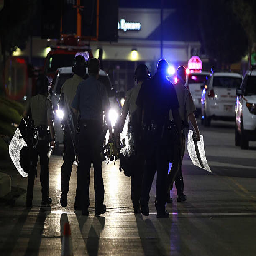

In [11]:
train_imgs_scaled =train_imgs_mat/ 255 
test_imgs_scaled = test_imgs_mat/255 
 
train_labels_enc = np_utils.to_categorical(train_labels)
 
test_labels_enc = np_utils.to_categorical(test_labels)

# visualize a sample image 
print(train_imgs_mat[0].shape) 
print(test_labels[:5])
array_to_img(train_imgs_mat[0])

Now, let's begin with the fun! Our work flow includes the following: 

1) Import a pre-trained model from Keras (in this case, a lovely ResNet50).

In [12]:
input_t = Input(shape=(256, 256, 3)) # The size of the images that we want the model to take. In this case 256 x 256 pixels (*)
res_model = ResNet50(weights="imagenet", input_tensor = input_t) # Import the canned model


102981632/102967424 [==============================] - 1s 0us/step


Let's explore the architecture and what's inside our model...

In [ ]:
for i,layer in enumerate(res_model.layers):
	print(i, layer.name, "-", layer.trainable)


Notice how all layers are trainable, meaning, we are using the FULL architecture, including the original labels, to potentially classify some pictures. Actually, let's try to classify a few pictures from the folder "ToyExample"

In [ ]:
base_direc = "/content/drive/MyDrive/"
img_path = base_direc+'ToyExample'
img_examples = [img_path+"/"+x for x in os.listdir(img_path)]

img_list = []
for i in img_examples:
  img = image.load_img(i, target_size=to_res)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  pred = res_model.predict(x)
  print('Image '+i+', Predicted:', decode_predictions(pred, top=2)[0])

49152/35363 [=========================================] - 0s 0us/step
Image /content/drive/MyDrive/ToyExample/tiger1.jpg, Predicted: [('n02129604', 'tiger', 0.8392114), ('n02123159', 'tiger_cat', 0.10575438)]
Image /content/drive/MyDrive/ToyExample/tiger2.jpg, Predicted: [('n02129604', 'tiger', 0.9263132), ('n02123159', 'tiger_cat', 0.04872005)]
Image /content/drive/MyDrive/ToyExample/tiger3.jpg, Predicted: [('n02129604', 'tiger', 0.7427509), ('n02123159', 'tiger_cat', 0.25015485)]
Image /content/drive/MyDrive/ToyExample/tiger4.jpg, Predicted: [('n02129604', 'tiger', 0.946469), ('n02123159', 'tiger_cat', 0.0381311)]
Image /content/drive/MyDrive/ToyExample/bear1.jpg, Predicted: [('n02134084', 'ice_bear', 0.9821602), ('n02104029', 'kuvasz', 0.015043302)]
Image /content/drive/MyDrive/ToyExample/bear2.jpg, Predicted: [('n02134084', 'ice_bear', 0.9884086), ('n02132136', 'brown_bear', 0.0050818874)]
Image /content/drive/MyDrive/ToyExample/bear3.jpg, Predicted: [('n02134084', 'ice_bear', 0.98

Great! It seems like it works... let's import the model again but now without the head (e.g. the pre-canned labels)

2) And then, let's "freeze" some layers, meaning, make them forget what they learned when the CNN was trained with the Imagenet dataset.

In [ ]:
model = ResNet50(include_top=False, weights="imagenet", input_tensor = input_t) # Import the canned model

for layer in res_model.layers[:143]:
	layer.trainable = False

# Sanity check to see if it worked!
for i,layer in enumerate(res_model.layers):
	print(i, layer.name, "-", layer.trainable)


94781440/94765736 [==============================] - 1s 0us/step
0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn

3) Modify the architecture of the pre-trained model according to your needs. Note that we did a LOT with this model. Let's go through some of the components:

In [ ]:
model = Sequential()

model.add(ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet', input_tensor=input_t))

model.add(Dense(3, activation = 'softmax'))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 6,147
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:

model.compile(optimizer = Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

4) Get our training data ready! This implies resizing (to fit the input of the original model we are using), normalizing, and "augmenting" the images in our set. This augmentation is a cool trick: it flips, turns, and modifies the images in our dataset so the CNN "learns" different variations of the same model. It is the cheapest way of enlarging your training data!

In [ ]:
train_datagen = ImageDataGenerator(zoom_range=0.3, rotation_range=50,
 width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
 horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_imgs_mat, train_labels_enc,batch_size=30)
test_generator = test_datagen.flow(test_imgs_mat, test_labels_enc, batch_size=30)
#print(tf.shape(train_gen.next()))

5) Train our model with our images of interest... be patient.

In [ ]:
history = model.fit(train_generator,epochs=10)

Epoch 1/10
14/14 [==============================] - 12s 590ms/step - loss: 1.1033 - accuracy: 0.5900
Epoch 2/10
14/14 [==============================] - 7s 504ms/step - loss: 0.8955 - accuracy: 0.6400
Epoch 3/10
14/14 [==============================] - 7s 490ms/step - loss: 0.8000 - accuracy: 0.6775
Epoch 4/10
14/14 [==============================] - 7s 490ms/step - loss: 0.7479 - accuracy: 0.6925
Epoch 5/10
14/14 [==============================] - 7s 483ms/step - loss: 0.7098 - accuracy: 0.7300
Epoch 6/10
14/14 [==============================] - 7s 493ms/step - loss: 0.6754 - accuracy: 0.7425
Epoch 7/10
14/14 [==============================] - 7s 499ms/step - loss: 0.6727 - accuracy: 0.7325
Epoch 8/10
14/14 [==============================] - 7s 493ms/step - loss: 0.6664 - accuracy: 0.7225
Epoch 9/10
14/14 [==============================] - 7s 496ms/step - loss: 0.5813 - accuracy: 0.7625
Epoch 10/10
14/14 [==============================] - 7s 489ms/step - loss: 0.6263 - accuracy: 0.750

6) ...and assess accuracy, mistakes, loss values, diagnostic plots, etc. until we are comfortable with the results (this does not mean, until we get the result we want but until we have some strong evidence that the model is correctly doing what we envisioned it should do!)



In [ ]:
preds = model.predict(test_generator)
y_int_pred = np.argmax(preds,axis=1)
print(preds[0:10])
print(y_int_pred[0:10])

[[0.832656   0.0434777  0.12386632]
 [0.55276304 0.38157475 0.06566219]
 [0.369465   0.03565796 0.59487706]
 [0.46914047 0.23733953 0.29352   ]
 [0.75394017 0.21973217 0.02632762]
 [0.9778568  0.02052767 0.00161554]
 [0.51949674 0.2711589  0.20934434]
 [0.00280647 0.06849016 0.92870337]
 [0.40830007 0.26792538 0.32377455]
 [0.4725432  0.31074625 0.21671057]]
[0 0 2 0 0 0 0 2 0 0]


In [ ]:
model.evaluate(test_generator, verbose=0)

[0.8262373208999634, 0.6650000214576721]

In [ ]:
y_true=[int(x) for x in test_labels]
print(confusion_matrix(y_true, y_int_pred))

[[99 16 20]
 [25  5  5]
 [23  2  5]]


7) Save the coefficients (errh... weights) of your model so you can predict out-of-sample labels --> Our ultimate objective! 



In [ ]:
model.save_weights(base_direc+"Model/tuned_weights_trust")